In [1]:
from collections import defaultdict
import itertools
import numpy as np

from benchmark import benchmark_chains
import blackjax
from blackjax.util import run_inference_algorithm
from sampling_algorithms import samplers
from inference_models import models
import jax.numpy as jnp
import math
import pandas as pd
from matplotlib import pyplot as plt
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState

import jax


In [2]:
def run_mclmc(logdensity_fn, num_steps, initial_position, key):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    kernel = blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
    )

    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
    )

    return blackjax_mclmc_sampler_params,


def get_optimal_params(model, sampler):

        _, _, params = benchmark_chains(models[model], samplers[sampler], batch=10, n = 100000, favg=models[model].E_x2, fvar=models[model].Var_x2)
        return params

In [3]:
def parameter_exploration(model, batch_size, N):

    
    results = defaultdict(float)

    optimal_step_size, optimal_L = get_optimal_params(model, 'mclmc')
    optimal_step_size, optimal_L = optimal_step_size.mean().item(), optimal_L.mean().item()

    def sampler_mclmc(step_size, L, noise):
        def s(logdensity_fn, num_steps, initial_position, key):
            alg = blackjax.mclmc(
            logdensity_fn=logdensity_fn,
            step_size=step_size,
            L=L,
            noise=noise
            )
            _, out, info = run_inference_algorithm(
            rng_key=key,
            initial_state_or_position=initial_position,
            inference_algorithm=alg,
            num_steps=num_steps, 
            transform=lambda x: x.position, 
            progress_bar=True)
            return out, 1, MCLMCAdaptationState(L, step_size)

        return s

    # for model in ["simple"]:
        # for step_size, L, noise, N in itertools.product([1.005], [16.765137], [1., 2.], np.linspace(100000.,2000000., 8)):
        #     N = N.astype(int)
        #     _, bias = benchmark_chains(models[model], sampler_mclmc(step_size, L, noise), batch=batch_size, n=N,favg=models[model].E_x2, fvar=models[model].Var_x2) #not using fvar and favg
        #     results[(model, step_size, L, noise, N)] = bias

    for step_size, L, noise, num_steps in itertools.product([optimal_step_size], [optimal_L], np.linspace(1e-1, 2, 20), [N]):
        _, bias, _ = benchmark_chains(models[model], sampler_mclmc(step_size, L, noise), batch=batch_size, n=num_steps,favg=models[model].E_x2, fvar=models[model].Var_x2) #not using fvar and favg
        results[(model, step_size, L, noise, N)] = bias

    for step_size, L, noise, num_steps in itertools.product(np.linspace(0.1,2, 10), [optimal_L], [0.0], [N]):
        _, bias, _ = benchmark_chains(models[model], sampler_mclmc(step_size, L, noise), batch=batch_size, n=num_steps,favg=models[model].E_x2, fvar=models[model].Var_x2) #not using fvar and favg
        results[(model, step_size, L, noise, N)] = bias

    return results, optimal_step_size, optimal_L



In [10]:
batch_size = 10
N = 1000000
model = "normal"
results, optimal_step_size, optimal_L = parameter_exploration("simple", batch_size=batch_size, N=N)


/opt/homebrew/Caskroom/miniconda/base/envs/mclmc/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/opt/homebrew/Caskroom/miniconda/base/envs/mclmc/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


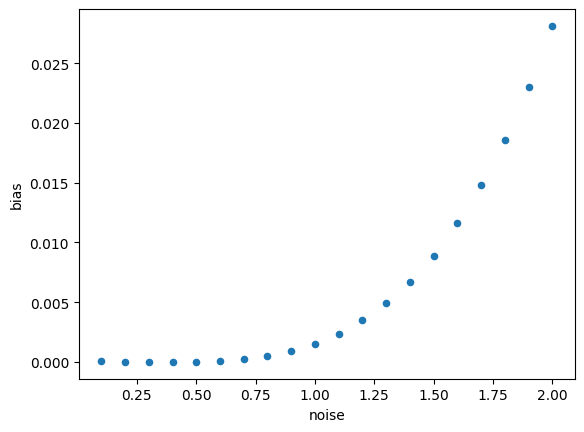

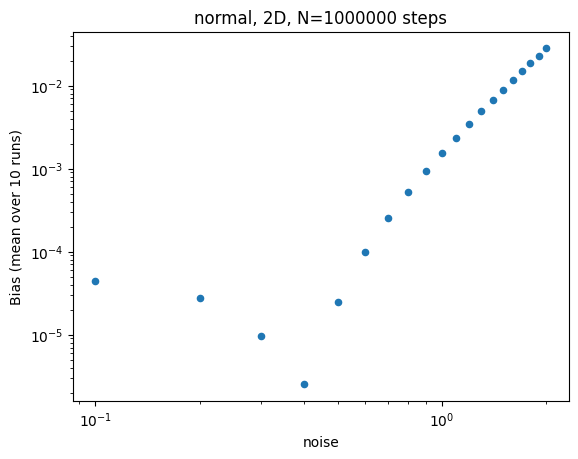

In [11]:
df = pd.Series(results).reset_index()
df.columns = ["model", "step_size", "L", "noise", "N", "bias"] 

df_1 = df[df.N==N]
df_1 = df_1[df_1.model=="simple"]
df_1 = df_1[df_1.step_size==optimal_step_size]
df_1 = df_1[df_1.L==optimal_L]
df_1

df_1.plot.scatter(x="noise", y="bias", colormap='viridis', )
df_1.plot.scatter(x="noise", y="bias", colormap='viridis', loglog=True)
plt.xlabel('noise')
plt.ylabel(f'Bias (mean over {batch_size} runs)')
plt.title(f'{model}, 2D, N={N} steps')
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/mclmc/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/opt/homebrew/Caskroom/miniconda/base/envs/mclmc/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


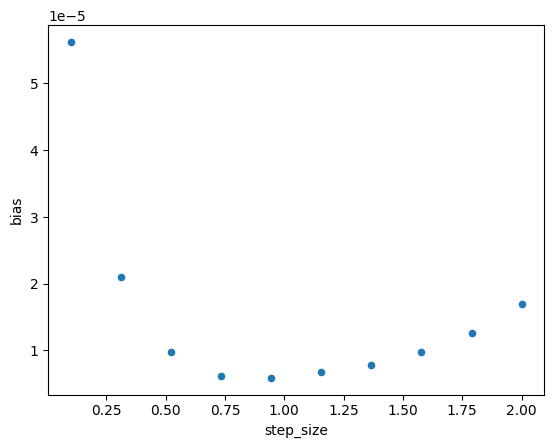

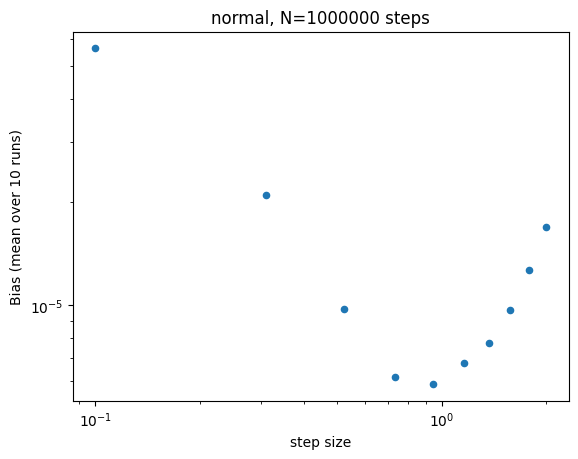

In [13]:
df_2 = df[df.N==N]
df_2 = df_2[df_2.model=="simple"]
df_2 = df_2[df_2.noise==0.0]
df_2 = df_2[df_2.L==optimal_L]
df_2

df_2.plot.scatter(x="step_size", y="bias", colormap='viridis')
df_2.plot.scatter(x="step_size", y="bias", colormap='viridis', loglog=True)
plt.xlabel('step size')
plt.ylabel(f'Bias (mean over {batch_size} runs)')
plt.title(f'{model}, N={N} steps')
plt.show()


In [14]:
# df_3 = df
# df_3 = df_3[df_3['N'] > 1000000]
# df_3 = df_3[df_3.model=="Banana"]
# df_3 = df_3[df_3.step_size==1.005]
# df_3 = df_3[df_3.L==16.765137]
# df_3


# df_3.plot.scatter(x="N", y="bias", colormap='viridis', c='noise')
# plt.xlabel('N')
# plt.ylabel(f'Bias (mean over {batch_size} runs)')
# plt.title(f'Banana, 2D, step size=1.005, L=16.765137')
# plt.show()